# Initialize NMRlipids databank

In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import MDAnalysis
import urllib.request
import yaml

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Databank/Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

apl.json not found from../../Databank/Data/Simulations/c3b/ff6/c3bff6e99c4e8c010bf13671f7aae6df192e12e7/fd6f540f5f44d50bfc059c16ce23db6666eb7810/
apl.json not found from../../Databank/Data/Simulations/8f4/59c/8f459c415f10c8871360ca97ce3d29b4ba956142/91b5cc9714f20ded49639d9dcbaeaf84566bf6d0/
apl.json not found from../../Databank/Data/Simulations/3b3/c1b/3b3c1bf43bc4a398f6baff75b2df1fa47e318f04/5f56d6196754d149b0e1b6a9dfade805e95511d9/
apl.json not found from../../Databank/Data/Simulations/930/5a2/9305a27f78b0ce37ba67c8f7108eaa8541529d77/31361c6cf8da078e8c4b5a0a478f8579bd119acb/


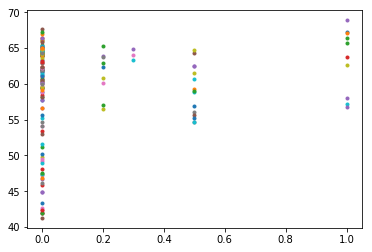

In [57]:
apl_DICT = {}
for system in systems:
    
    try:
        NPOPG = np.sum(system['COMPOSITION']['POPG']['COUNT'])
    except:
        NPOPG = 0    
    
    try:
        NPOPC = np.sum(system['COMPOSITION']['POPC']['COUNT'])
    except:
        NPOPC = 0
    
    if NPOPG == 0 and NPOPC == 0:
        continue
    
    
    APLpath = system['path'] + 'apl.json'
    try:
        f = open(APLpath)
        APLdata = json.load(f)
    except:
        print('apl.json not found from' + system['path'])
        
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    
    plt.plot(NPOPG / (NPOPG + NPOPC), APL,'.')
    
    try:
        CaConcentration = system['COMPOSITION']['CAL']['COUNT'] * 55.5 / system['COMPOSITION']['SOL']['COUNT']
    except:
        CaConcentration = 0
    lipidsRATIO = 100*NPOPG / (NPOPG + NPOPC)
    forcefield = system.get('FF')
    temperature = system.get('TEMPERATURE')
    DOI = system.get('DOI')
    apl_DICT[lipidsRATIO,CaConcentration,forcefield,temperature,DOI] = APL
   

In [55]:
for key in apl_DICT:
    print(key)
    #DataName = str(key[2]) + str(key[3])
    #if not DataName:
    #    DataName = []
    #DataName.append

(16.666666666666668, 0.1388739946380697, 'CHARMM36 with NBFIX for calcium ions', 320.0, '10.5281/zenodo.3371327')
(0.0, 0, 'CHARMM36', 303.0, '10.5281/zenodo.3474863')
(0.0, 0.45016666666666666, 'CHARMM36 with incorrect multiplicity in dihedrals and ECC ions', 310.15, '10.5281/zenodo.259376')
(0.0, 0, 'CHARMM36', 310.15, '10.5281/zenodo.545941')
(0.0, 0, 'slipids', 298.0, '10.5281/zenodo.159434')
(0.0, 0, 'CHARMM36', 303.0, '10.5281/zenodo.13945')
(0.0, 0.45016666666666666, 'CHARMM36', 310.15, '10.5281/zenodo.1198171')
(0.0, 0.45016666666666666, 'CHARMM36', 310.15, '10.5281/zenodo.51185')
(16.666666666666668, 0, 'CHARMM36', 298.0, '10.5281/zenodo.1493241')
(0.0, 0, 'CHARMM36', 298.0, '10.5281/zenodo.3997116')
(0.0, 0.45016666666666666, 'ECC-CHARMM36', 310.15, '10.5281/zenodo.2562079')
(0.0, 0, 'lipid17', 310.0, '10.5281/zenodo.3241243')
(0.0, 0, 'CHARMM36', 300.0, '10.5281/zenodo.1306800')
(0.0, 0, 'CHARMM36', 303.0, '10.5281/zenodo.164206')
(0.0, 1.0574083375188348, 'lipid17ecc', 298.

In [59]:
for key in apl_DICT:
    outfile=open('./results/' + str(key[2]) + "_T" + str(key[3]) + "_CaCl" + str(round(key[1],3)) + 'PCPG_APL.dat','w')
    #outfile.write('#Lipid ratio        APL \n')
    outfile.close()
                    
for key in apl_DICT:
    outfile=open('./results/' + str(key[2]) + "_T" + str(key[3]) + "_CaCl" + str(round(key[1],3)) + 'PCPG_APL.dat','a')
    #Lipid2cont = int(round(key[0]))
    #CaConsentration = key[1]
    outfile.write(str(round(key[0],3)) + " " + str(apl_DICT[key]) + " " + str(key[4]))
    outfile.write('\n')
    outfile.close()
    !sort -n -k 1 {'./results/' + str(key[2]) + "_T" + str(key[3]) + "_CaCl" + str(round(key[1],3)) + 'PCPG_APL.dat'} -o {'./results/' + str(key[2]) + "_T" + str(key[3]) + "_CaCl" + str(round(key[1],3)) + 'PCPG_APL.dat'}
#plt.legend(loc='best',ncol=2, fontsize=15)

sort: cannot read: ./results/CHARMM36: No such file or directory
sort: cannot read: ./results/CHARMM36: No such file or directory
sort: cannot read: ./results/CHARMM36: No such file or directory
/bin/sh: 1: Syntax error: "(" unexpected
/bin/sh: 1: Syntax error: "(" unexpected
sort: cannot read: ./results/Slipids: No such file or directory
/bin/sh: 1: Dang_T310.0_CaCl0PCPG_APL.dat: not found
sort: cannot read: ./results/CHARMM36: No such file or directory
/bin/sh: 1: Syntax error: "(" unexpected
sort: cannot read: ./results/CHARMM36: No such file or directory
sort: cannot read: ./results/CHARMM36: No such file or directory
sort: cannot read: ./results/CHARMM36: No such file or directory
sort: cannot read: ./results/CHARMM36: No such file or directory
sort: cannot read: ./results/Slipids: No such file or directory
sort: cannot read: ./results/CHARMM36: No such file or directory
sort: cannot read: ./results/Slipids: No such file or directory
/bin/sh: 1: Syntax error: "(" unexpected


FileNotFoundError: [Errno 2] No such file or directory: '../Figs/aplTST.png'

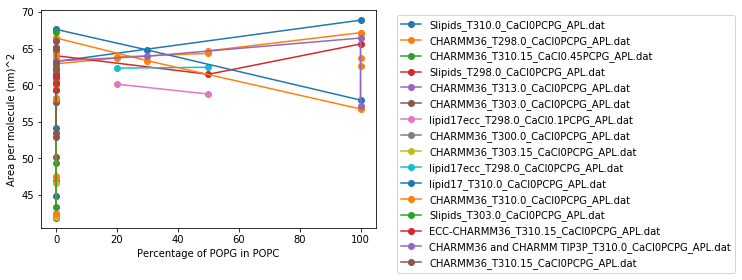

In [60]:
for subdir, dirs, files in os.walk(r'./results/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("APL.dat"):
            with open(filepath) as APLfile:
                lines = APLfile.readlines()#[1:]
                x = [float(line.split()[0]) for line in lines]
                y = [float(line.split()[1]) for line in lines]
                #print(filepath,x,y)
                if len(x) > 1:
                    plt.plot(x,y,label = filename,marker='o')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.xlabel('Percentage of POPG in POPC')
plt.ylabel('Area per molecule (nm)^2')
plt.savefig('../Figs/aplTST.png', bbox_inches='tight')